Imports

In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import shuffle
from PIL import Image
from tensorflow.keras import backend as K    
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Part 0: Load in pneumonia/healthy data to train CNN on

We will be training a CNN with a large pneumonia/healthy chest x-ray dataset and use transfer learning to train it for COVID/Non-COVID

In [58]:
init_d = {'filename': [], 'target': []}

# format: (file location, healthy/pneumonia(0/1))
files = [('train/Normal', 0), 
         ('train/Pneumonia', 1),
         ('test/Normal', 0), 
         ('test/Pneumonia', 1),
         ('val/Normal', 0), 
         ('val/Pneumonia', 1),]

for file in files:
    dir_path = os.path.abspath(os.getcwd())
    dir_path = dir_path + "/chest_xray/" + file[0]
    list = os.listdir(dir_path)
    for pic in list:
        if '.DS_Store' not in pic:
            init_d['filename'].append(pic)
            init_d['target'].append(file[1])

# Part 1: Preprocessing for images
Load in images for the corresponding target data with PIL. Reformat all images to the same dimensions and convert them to a numpy array for the models to use (where each is a (# pixels, # pixels) array).

In [61]:
# Load in image data from filenames with PIL
img_dim = 128
def normalize_images(d, curr_dir):
    """normalize all images inside dictionary"""
    images = np.empty((len(d['target']), img_dim, img_dim, 2))

    for i in range(len(d['filename'])):
        image = Image.open(curr_dir + d['filename'][i])

        # resize image shape
        image = image.resize((img_dim, img_dim))

        # convert to grayscale
        image = image.convert('LA')

        images[i] = np.array(image)

    # normalize values
    images = images / 255.0
    return images

In [62]:
# get train/test/val images
images = normalize_images(init_d, "chest_xray/pooled_imgs/")

### Data Augmenation

In [86]:
aug_count = 15
def augment_images(images, targets):
    data_augmentation = tf.keras.Sequential([
      layers.experimental.preprocessing.RandomFlip("horizontal", dtype='float64'),
      layers.experimental.preprocessing.RandomRotation(0.05, dtype='float64')
    ])
    
    aug_images = np.empty((len(targets * (aug_count + 1)), img_dim, img_dim, 2))
    new_targets = []
    
    
    for i in range(len(targets)):
        image = tf.expand_dims(images[i], 0)
        for j in range(0, aug_count):
            new_image = data_augmentation(image)
            new_targets.append(targets[i])
            aug_images[len(new_targets) - 1] = new_image[0]
        
        # add base image
        new_targets.append(targets[i])
        aug_images[len(new_targets) - 1] = images[i]
    
    return np.asarray(aug_images), new_targets

# Part 2: Train Pneumonia/Healthy Classifier with CNN

In [69]:
# split data
x_train1, x_test1, y_train1, y_test1 = train_test_split(images, init_d["targets"], test_size=0.20, random_state=0)
x_train1, x_val1, y_train1, y_val1 = train_test_split(x_train1, y_train1, test_size=0.20, random_state=0)
y_train1 = np.asarray(y_train1)
y_val1 = np.asarray(y_val1)
y_test1 = np.asarray(y_test1)

In [ ]:
x_train1, y_train1 = augment_images(x_train1, y_train1)
print("base image count: ", len(y_train1))

In [70]:
# build model for convolutional network
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_dim, img_dim, 2), padding='same'))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))


# add more layers
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(2))

# compile 
cnn_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      608       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)      

In [71]:
# Set up early stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-2,
        verbose=1
    )
]

history = cnn_model.fit(x_train1, y_train1, epochs=10,
                       validation_data=(x_val1, y_val1),
                       callbacks=callbacks)

Epoch 1/10
1055/1055 [==============================] - 1198s 1s/step - loss: 0.3177 - accuracy: 0.8572 - val_loss: 0.1584 - val_accuracy: 0.9388
Epoch 2/10
1055/1055 [==============================] - 1139s 1s/step - loss: 0.1254 - accuracy: 0.9525 - val_loss: 0.1217 - val_accuracy: 0.9565
Epoch 3/10
1055/1055 [==============================] - 1177s 1s/step - loss: 0.0955 - accuracy: 0.9647 - val_loss: 0.1241 - val_accuracy: 0.9632
Epoch 00003: early stopping


In [72]:
# save model
cnn_model.save('basemodel_aug/')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: basemodel_aug/assets


330/330 - 70s - loss: 0.1120 - accuracy: 0.9658


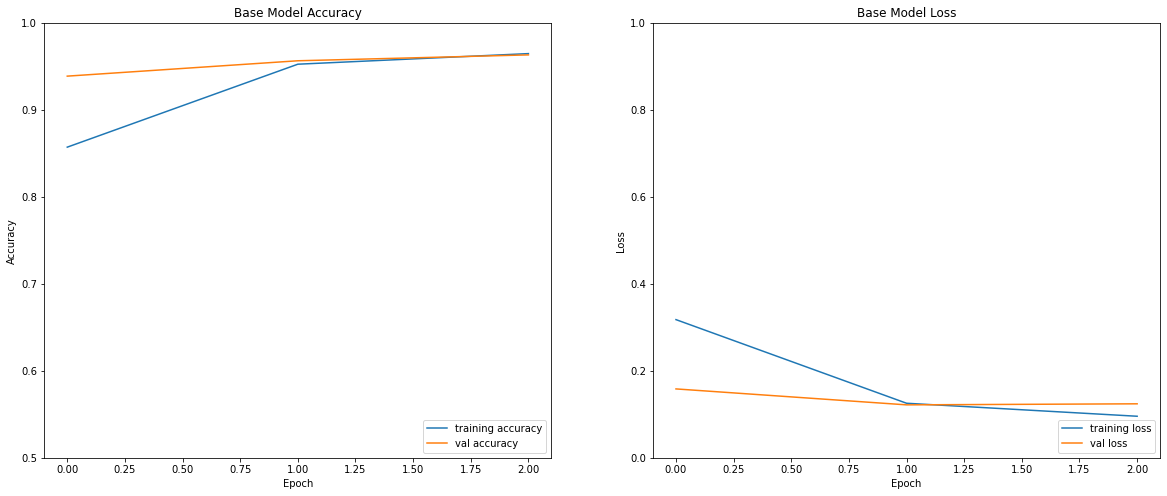

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].plot(history.history['accuracy'], label='training accuracy')
axs[0].plot(history.history['val_accuracy'], label = 'val accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Base Model Accuracy')
axs[0].set_ylim([0.5, 1])
axs[0].legend(loc='lower right')

axs[1].plot(history.history['loss'], label='training loss')
axs[1].plot(history.history['val_loss'], label = 'val loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Base Model Loss')
axs[1].set_ylim([0, 1])
axs[1].legend(loc='lower right')

test_loss, test_acc = cnn_model.evaluate(x_test1, y_test1, verbose=2)

# Part 3: Load in COVID Data

Read in csv of metadata for the images and select target data. For our target data we are selecting COVID/Non-COVID, Survival, Intubation, and Admission to the ICU - resulting in 28 classes where class 0 = Non-COVID and class > 0 is COVID and some unique combination of the classes above. For the initial training and testing of this data, any class > 0 we set to 1 to train a binary classifier for COVID/Non-COVID

In [74]:
data = []
with open("metadata.csv") as file:
    for row in csv.reader(file):
        data.append(row)

data = data[1:]

d = {'filename': [], 'target': []}

for image in data:
    # skip volume data
    if image[22] == "volumes":
        continue
    
    # ignore CT scan data
    if image[19] == "CT":
        continue
    
    diagnosis = image[4].split("/")
    diagnosis = diagnosis[len(diagnosis) - 1].lower()
    # set target based on meta data
    if diagnosis != "covid-19":
        if diagnosis == "todo":
            # if not classified yet target = -1
            # d['filename'].append(image[23])
            # d['target'].append(-1)
            # ignore unknown data
            continue
        else:
            # if not COVID-19 target = 0
            d['filename'].append(image[23])
            d['target'].append(0)
    else:
        # if it is COVID-19
        d['filename'].append(image[23])
        d['target'].append(1)
        
file.close()


In [75]:
# preprocess covid/noncovid images
covid_images = normalize_images(d, "model_images/")

### Augmentation

In [87]:
covid_images_aug, targets = augment_images(covid_images, d['target'])

In [88]:
print("covid image count: ", len(covid_images_aug))

covid image count:  12528


TypeError: Invalid shape (128, 128, 2) for image data

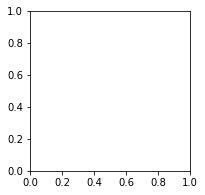

In [80]:
plt.figure(figsize=(10, 10))
for i in range(aug_count + 1):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(covid_images_aug[i], cmap='gray', vmin=0, vmax=255)
  plt.axis("off")

# Part 2: Train COVID/Non-COVID with Transfer Learning

In [89]:
# split data
x_train, x_test, y_train, y_test = train_test_split(covid_images, d["target"], test_size=0.20, random_state=2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=2)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

In [ ]:
x_train, y_train = augment_images(x_train, y_train)
print("base image count: ", len(y_train))

In [90]:
def build_covid_model(learn_rate=0.01, dropout_rate=0.0, 
                      layers=(128, 128), num_classes=2, decay_rate=0.8, decay_steps=100000):
    base_model = tf.keras.models.load_model('basemodel_aug/')
    covid_model = models.Sequential()

    # add all layers except densely connected to new model
    for layer in base_model.layers[:-2]:
        layer.trainable = False
        covid_model.add(layer)

    # add new dense layers on top of old model
    #covid_model.add(layers.Dense(64, activation='relu'))
    try:
        for neurons in layers:
            covid_model.add(tf.keras.layers.Dense(int(neurons)))
            covid_model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
            covid_model.add(tf.keras.layers.BatchNormalization())
    except:
        covid_model.add(tf.keras.layers.Dense(layers))
        covid_model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
        covid_model.add(tf.keras.layers.BatchNormalization())
    
    covid_model.add(tf.keras.layers.Dropout(dropout_rate))
    
    # set new low learning rate for fine-tuning
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learn_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate)

    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    if num_classes == 2:
        covid_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        covid_model.compile(optimizer=opt,
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=['accuracy'])
    else:
        covid_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
        covid_model.compile(optimizer=opt,
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])

    return covid_model


In [43]:
# make classifier
covid_test_model = KerasClassifier(
    build_fn = build_covid_model,
    learn_rate = 0.001,
    dropout_rate = 0.6,
    layers=(128, 128, 128),
    num_classes=2,
    decay_rate=0.8,
    decay_steps=100000
)

# random search http://ethen8181.github.io/machine-learning/keras/nn_keras_hyperparameter_tuning.html
learning_rates = [0.001, 0.01, 0.0005, 0.0001]
dropout_rates = [0.2, 0.4, 0.6]
dif_layers = [(64), (64, 64), (128), (32), (128, 128, 128)]
decay_rates = [0.5, 0.7, 0.8, 0.85, 0.65, 0.55]
decay_step = [100000, 10000, 50000, 80000]
distributions = dict(layers=dif_layers, 
                     dropout_rate=dropout_rates, decay_rate=decay_rates, decay_steps=decay_step)

clf = RandomizedSearchCV(covid_test_model, distributions, random_state=0, n_jobs=-1, 
                         scoring="roc_auc", verbose=10, cv=2)
search = clf.fit(covid_images_aug, targets)
search.best_params_

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed:  5.7min remaining: 22.8min
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed:  5.7min remaining: 10.6min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:  5.8min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  13 out of  20 | elapsed:  5.8min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:  5.8min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  7.1min finished


221/221 [==============================] - 25s 112ms/step - loss: 0.5274 - accuracy: 0.7443


{'layers': (64, 64),
 'dropout_rate': 0.2,
 'decay_steps': 80000,
 'decay_rate': 0.7}

In [91]:
# build model
covid_model = build_covid_model(learn_rate=0.001, dropout_rate=0.2, layers=(64, 64), 
                                num_classes = 2, decay_rate=0.7, decay_steps=50000)

#covid_model.summary()

In [92]:
# setup early stopping: https://www.tensorflow.org/guide/keras/train_and_evaluate
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-2,
        patience=2,
        verbose=1
    )
]

covid_history = covid_model.fit(x_train, y_train, epochs=10,
                               validation_data=(x_val, y_val),
                               #callbacks=callbacks
                               )

Epoch 1/10
251/251 [==============================] - 69s 277ms/step - loss: 0.4904 - accuracy: 0.7692 - val_loss: 0.4076 - val_accuracy: 0.8254
Epoch 2/10
251/251 [==============================] - 72s 285ms/step - loss: 0.2745 - accuracy: 0.8876 - val_loss: 0.2533 - val_accuracy: 0.8958
Epoch 3/10
251/251 [==============================] - 70s 277ms/step - loss: 0.1843 - accuracy: 0.9292 - val_loss: 0.2193 - val_accuracy: 0.9182
Epoch 4/10
251/251 [==============================] - 77s 308ms/step - loss: 0.1256 - accuracy: 0.9541 - val_loss: 0.1631 - val_accuracy: 0.9421
Epoch 5/10
251/251 [==============================] - 75s 299ms/step - loss: 0.0864 - accuracy: 0.9703 - val_loss: 0.1667 - val_accuracy: 0.9387
Epoch 6/10
251/251 [==============================] - 70s 277ms/step - loss: 0.0866 - accuracy: 0.9696 - val_loss: 0.1710 - val_accuracy: 0.9357
Epoch 7/10
251/251 [==============================] - 71s 285ms/step - loss: 0.0618 - accuracy: 0.9780 - val_loss: 0.1639 - val_ac

KeyboardInterrupt: 

Area under the curve:  0.9596620935906064


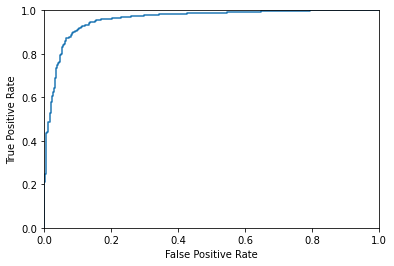

In [84]:
# plot ROC curve
y_predict = covid_model.predict(x_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_predict)

auc_val = auc(fpr, tpr)

print("Area under the curve: ", auc_val)

plt.plot(fpr,tpr) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()  

45/45 - 10s - loss: 0.2844 - accuracy: 0.9121


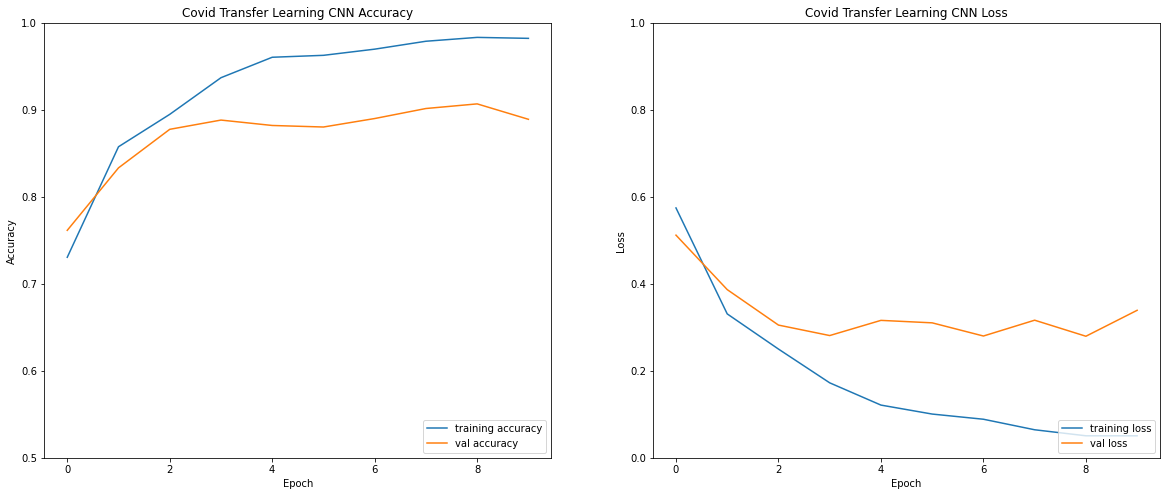

In [85]:
# plot accuracy and loss curves
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].plot(covid_history.history['accuracy'], label='training accuracy')
axs[0].plot(covid_history.history['val_accuracy'], label = 'val accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Covid Transfer Learning CNN Accuracy')
axs[0].set_ylim([0.5, 1])
axs[0].legend(loc='lower right')

axs[1].plot(covid_history.history['loss'], label='training loss')
axs[1].plot(covid_history.history['val_loss'], label = 'val loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Covid Transfer Learning CNN Loss')
axs[1].set_ylim([0, 1])
axs[1].legend(loc='lower right')

test_loss, test_acc = covid_model.evaluate(x_test, y_test, verbose=2)

# Part 4: Additional Classes for Covid Prediction

In [397]:
data = []
with open("metadata.csv") as file:
    for row in csv.reader(file):
        data.append(row)

data = data[1:]

d_pred = {'filename': [], 'target': []}

for image in data:
    # skip volume data
    if image[22] == "volumes":
        continue
    
    # ignore CT scan data
    if image[19] == "CT":
        continue
    
    diagnosis = image[4].split("/")
    diagnosis = diagnosis[len(diagnosis) - 1].lower()
    # set target based on meta data
    if diagnosis != "covid-19":
        if diagnosis == "todo":
            # if not classified yet target = -1
            # d['filename'].append(image[23])
            # d['target'].append(-1)
            # ignore unknown data
            continue
        else:
            # if not COVID-19 target = 0
            d_pred['filename'].append(image[23])
            d_pred['target'].append(0)
    else:
        # if it is COVID-19
        if image[6] == "Y":
            # if they survived
            d_pred['filename'].append(image[23])
            d_pred['target'].append(1)
        elif image[6] == "N":
            # if they did not survive
            d_pred['filename'].append(image[23])
            d_pred['target'].append(2)

file.close()


In [398]:
# preprocess covid/noncovid images
covid_pred_images = normalize_images(d_pred, "model_images/")

### Augmentation

In [399]:
covid_pred_images_aug, pred_targets = augment_images(covid_pred_images, d_pred['target'])

### Train Prediction Model

In [400]:
# split data
x_train, x_test, y_train, y_test = train_test_split(covid_pred_images_aug, pred_targets, test_size=0.20, random_state=2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=2)
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

In [401]:
base_model = tf.keras.models.load_model('basemodel_aug/')
pred_model = models.Sequential()

# add all layers except densely connected to new model
for layer in base_model.layers[:-2]:
    layer.trainable = False
    pred_model.add(layer)

# add new dense layers on top of old model
#covid_model.add(layers.Dense(64, activation='relu'))
pred_model.add(layers.Dense(64, activation='relu'))
pred_model.add(layers.Dropout(0.5))
pred_model.add(layers.Dense(3, activation='softmax'))

pred_model.summary()

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_126 (Conv2D)          (None, 96, 96, 32)        896       
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_76 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 48, 48, 64)        36928     
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 24, 24, 64)      

In [402]:
# set new low learning rate for fine-tuning
opt = tf.keras.optimizers.Adam(lr=0.001)
pred_model.compile(optimizer=opt,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

In [403]:
pred_history = pred_model.fit(x_train, y_train, epochs=10,
                              validation_data=(x_val, y_val),
                             callbacks=callbacks)

Epoch 1/10
83/83 [==============================] - 13s 156ms/step - loss: 0.9168 - accuracy: 0.6214 - val_loss: 0.8655 - val_accuracy: 0.6606
Epoch 2/10
83/83 [==============================] - 13s 161ms/step - loss: 0.8122 - accuracy: 0.7433 - val_loss: 0.8070 - val_accuracy: 0.7406
Epoch 3/10
83/83 [==============================] - 14s 166ms/step - loss: 0.7594 - accuracy: 0.7984 - val_loss: 0.7899 - val_accuracy: 0.7526
Epoch 4/10
83/83 [==============================] - 13s 157ms/step - loss: 0.7281 - accuracy: 0.8294 - val_loss: 0.7823 - val_accuracy: 0.7662
Epoch 5/10
83/83 [==============================] - 14s 163ms/step - loss: 0.7018 - accuracy: 0.8569 - val_loss: 0.7623 - val_accuracy: 0.7813
Epoch 6/10
83/83 [==============================] - 13s 159ms/step - loss: 0.6906 - accuracy: 0.8656 - val_loss: 0.7609 - val_accuracy: 0.7843
Epoch 7/10
83/83 [==============================] - 13s 157ms/step - loss: 0.6713 - accuracy: 0.8856 - val_loss: 0.7530 - val_accuracy: 0.7934

26/26 - 3s - loss: 0.7549 - accuracy: 0.7874


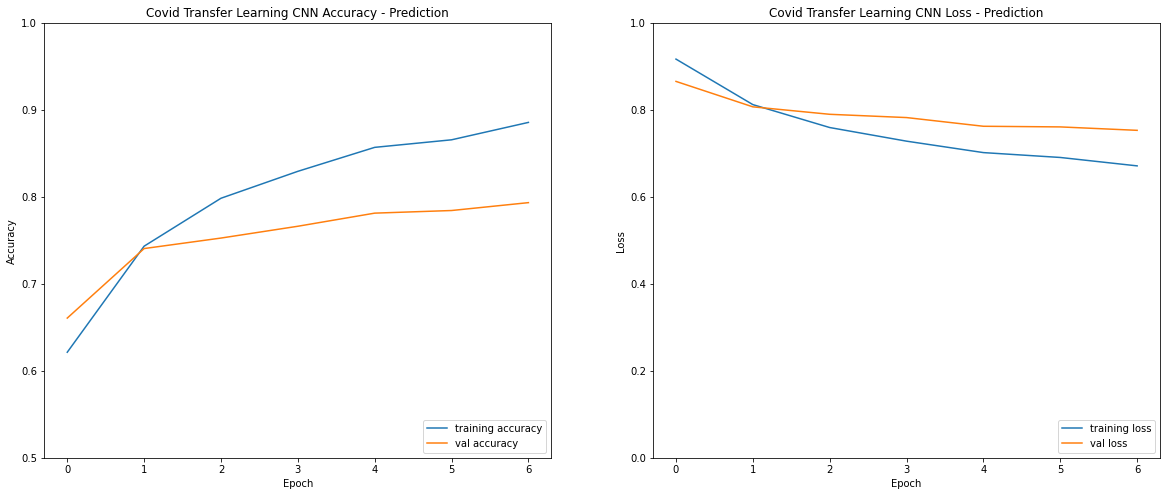

In [404]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].plot(pred_history.history['accuracy'], label='training accuracy')
axs[0].plot(pred_history.history['val_accuracy'], label = 'val accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Covid Transfer Learning CNN Accuracy - Prediction')
axs[0].set_ylim([0.5, 1])
axs[0].legend(loc='lower right')

axs[1].plot(pred_history.history['loss'], label='training loss')
axs[1].plot(pred_history.history['val_loss'], label = 'val loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Covid Transfer Learning CNN Loss - Prediction')
axs[1].set_ylim([0, 1])
axs[1].legend(loc='lower right')

test_loss, test_acc = pred_model.evaluate(x_test, y_test, verbose=2)

# Part 5: 

In [ ]:
def graph_correlation(images, targets, classes):
    reshaped_images = np.empty((len(targets), img_dim * img_dim * 2))
    for i in range(len(targets)):
    reshaped_images[i] = images[i].ravel()

     pca = PCA(n_components=2)
    redData = pca.fit_transform(reshaped_images)
    # append target values to reduced data
    redData = np.append(redData, np.asarray(targets).reshape(-1, 1), axis=1)
     # create scatter plot of reduced data
    # add scatter plot for each of the target values
    for curr in classes:
    currClass = np.where(np.asarray(d['target']) == curr)
    plt.scatter(redData[:, 0][currClass], redData[:, 1][currClass])
    plt.legend(classes)


In [ ]:
print("covid/healthy default")
graph_correlation(covid_images, d['target'], [0, 1])